In [13]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

class SegmentationModule:
    """
    Segmentação semântica da pessoa na imagem.
    - Usa modelo DeepLabV3 pré-treinado do torchvision.
    - Retorna a máscara binária da pessoa (silhueta) e a imagem original.
    """

    def __init__(self):
        # Carrega modelo DeepLabV3 com backbone ResNet50, pré-treinado no COCO
        self.model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
        self.model.eval()  # modo avaliação, desativa dropout etc.

        # Pré-processamento: redimensionar para 512x512 e converter para tensor
        self.preprocess = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor(),
        ])
    
    def extract_silhouette(self, image_path):
        # Abrir imagem com PIL e converter para RGB
        img = Image.open(image_path).convert("RGB")

        # Pré-processar e adicionar dimensão batch (1, C, H, W)
        input_tensor = self.preprocess(img).unsqueeze(0)

        # Forward pass do modelo para segmentação
        with torch.no_grad():
            output = self.model(input_tensor)['out'][0]  # saída do modelo

        # COCO class 15 = pessoa
        mask = (output.argmax(0) == 15).byte().cpu().numpy()  # 1=pessoa, 0=fundo
        mask_img = mask * 255  # escala para 0-255 para visualização

        # Mostrar imagem original e silhueta lado a lado
        fig, axs = plt.subplots(1,2, figsize=(8,4))
        axs[0].imshow(img)
        axs[0].set_title("Imagem Original")
        axs[1].imshow(mask_img, cmap="gray")
        axs[1].set_title("Silhueta Extraída")
        for ax in axs: ax.axis("off")
        plt.show()

        # Retorna máscara binária e imagem original como array numpy
        return mask_img, np.array(img)

In [14]:
class KeypointsModule:
    """
    Detecta pontos-chave aproximados da silhueta da pessoa.
    Abordagem simplificada sem usar MediaPipe:
    - Usa o contorno da silhueta para localizar o corpo.
    - Calcula uma bounding box (retângulo) ao redor do contorno.
    - Estima keypoints com base em proporções dentro da bounding box.
    """

    def extract_keypoints(self, mask):
        # Encontrar todos os contornos na máscara
        # cv2.RETR_EXTERNAL -> pega apenas os contornos externos
        # cv2.CHAIN_APPROX_SIMPLE -> reduz número de pontos do contorno
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if len(contours) == 0:
            # Nenhum contorno encontrado → retorna dicionário vazio
            return {}

        # Seleciona o maior contorno, que corresponde à pessoa
        c = max(contours, key=cv2.contourArea)

        # Calcula a bounding box do contorno
        # x, y -> canto superior esquerdo da caixa
        # w, h -> largura e altura da caixa
        x, y, w, h = cv2.boundingRect(c)

        # Estima keypoints com base em proporções da bounding box
        keypoints = {
            'top_head': (x + w//2, y),                # topo da cabeça
            'neck': (x + w//2, y + h//10),           # pescoço (10% da altura)
            'shoulders': (x + w//2, y + h//5),       # ombros (20% da altura)
            'waist': (x + w//2, y + h//2),           # cintura (50% da altura)
            'hips': (x + w//2, y + int(h*0.6)),      # quadril (60% da altura)
            'knees': (x + w//2, y + int(h*0.8)),     # joelhos (80% da altura)
            'ankles': (x + w//2, y + h),             # tornozelos (base da bounding box)
        }

        # Retorna dicionário com keypoints aproximados
        return keypoints

In [15]:
import numpy as np

class RegressionModule:
    """
    Converte keypoints em medidas corporais aproximadas.
    Para protótipo, gera valores simulados baseados em proporções.
    """
    def predict_measures(self, keypoints):
        measures = {}
        if not keypoints:
            return measures

        # Exemplo: usar distância entre pontos como proxy
        def distance(p1, p2):
            return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

        measures['pescoço'] = distance(keypoints['top_head'], keypoints['neck']) * 1.2
        measures['peito'] = distance(keypoints['shoulders'], keypoints['waist']) * 2
        measures['cintura'] = distance(keypoints['waist'], keypoints['hips']) * 1.5
        measures['quadril'] = distance(keypoints['hips'], keypoints['knees']) * 1.3
        measures['coxa'] = distance(keypoints['hips'], keypoints['knees'])
        measures['joelho'] = distance(keypoints['knees'], keypoints['ankles'])
        measures['panturrilha'] = distance(keypoints['knees'], keypoints['ankles']) * 0.7
        measures['abdomen'] = measures['cintura'] * 0.9
        measures['biceps'] = measures['peito'] * 0.3

        return measures

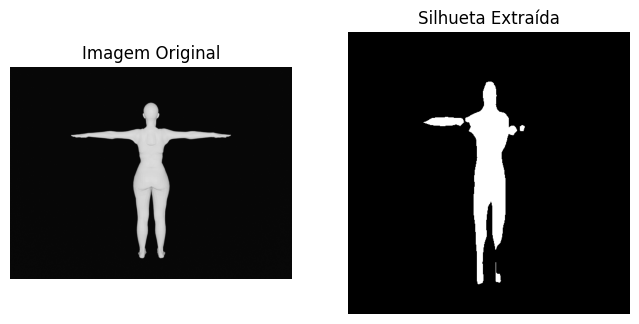

Medidas estimadas (aproximadas):
pescoço: 43.20 px
peito: 222.00 px
cintura: 54.00 px
quadril: 96.20 px
coxa: 74.00 px
joelho: 74.00 px
panturrilha: 51.80 px
abdomen: 48.60 px
biceps: 66.60 px


In [17]:
# main_pipeline.py
seg_module = SegmentationModule()
kp_module = KeypointsModule()
reg_module = RegressionModule()

mask, image = seg_module.extract_silhouette("female-001289_B00.png")
keypoints = kp_module.extract_keypoints(mask)
measures = reg_module.predict_measures(keypoints)

print("Medidas estimadas (aproximadas):")
for k,v in measures.items():
    print(f"{k}: {v:.2f} px")